In [16]:
from argparse import ArgumentParser

import torch
import wandb
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from preprocessing.data_pipeline import build_data_pipeline
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from preprocessing.preprocess_ucr import UCRDatasetImporter
from experiments.exp_maskgit import ExpMaskGIT
from evaluation.model_eval import Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from models.stage2.maskgit import MaskGIT
import os
from pathlib import Path
import tempfile

# from evaluation.evaluation import Evaluation
from utils import (
    get_root_dir,
    load_yaml_param_settings,
    save_model,
    model_filename,
)



config_dir = get_root_dir().joinpath("configs", "config.yaml")
dataset="UWaveGestureLibraryAll"
config = load_yaml_param_settings(config_dir)
config["dataset"]["dataset_name"] = dataset

dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]

train_data_loader_no_aug = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="train"
)

test_data_loader_no_aug = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="test"
)


input_length = train_data_loader_no_aug.dataset.X.shape[-1]

n_classes = len(np.unique(train_data_loader_no_aug.dataset.Y))

maskgit = MaskGIT(
    input_length,
    **config["MaskGIT"],
    config=config,
    n_classes=n_classes,
)

# load
fname = f"maskgit-{dataset}.ckpt"
try:
    ckpt_fname = os.path.join("saved_models", fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
except FileNotFoundError:
    ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)



self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
encoder-UWaveGestureLibraryAll.ckpt
 encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
decoder-UWaveGestureLibraryAll.ckpt
 decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vqmodel-UWaveGestureLibraryAll.ckpt
 vqmodel loaded


In [2]:
eval = Evaluation(dataset, 0, config, batch_size)

self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]


In [3]:
samples, agg_probs, agg_entropy, agg_sel_entropy  = eval.aggregate_statistics(maskgit, 10)

100%|██████████| 10/10 [00:00<00:00, 19.93it/s]


In [4]:
co_occurence = eval.co_occurence_matrix(samples, maskgit.mask_token_ids)

Text(0.5, 1.0, 'Off Diagonal Pointwise Mutual Information of Tokens')

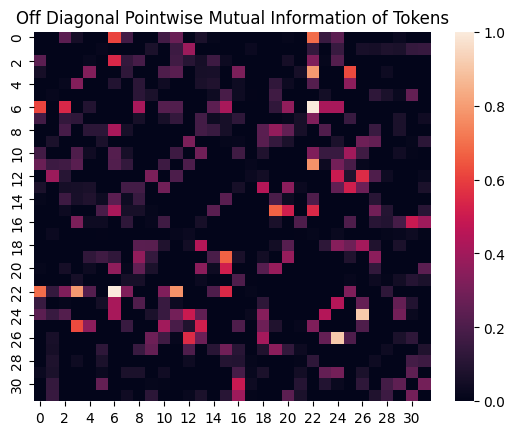

In [5]:
token_prob, joint_prob, conditional_prob = eval.calculate_probabilities(co_occurence)

pmi = eval.calculate_pmi(token_prob, joint_prob)

pmi = pmi.fill_diagonal_(0)
sns.heatmap(pmi)
plt.title("Off Diagonal Pointwise Mutual Information of Tokens")


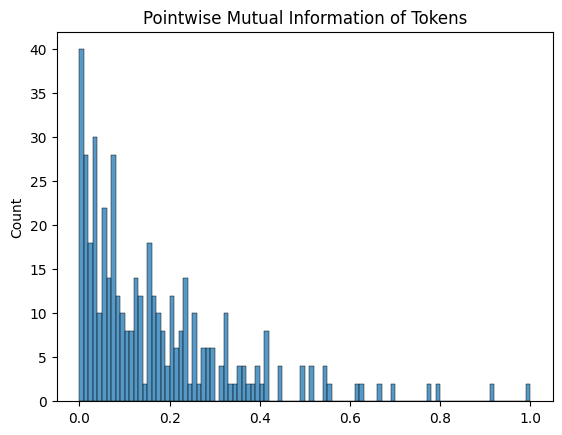

In [6]:
pmi_flat = pmi.flatten()
pmi_flat = pmi_flat[pmi_flat != 0]
sns.histplot(pmi_flat, bins=100)
plt.title("Pointwise Mutual Information of Tokens")
plt.show()

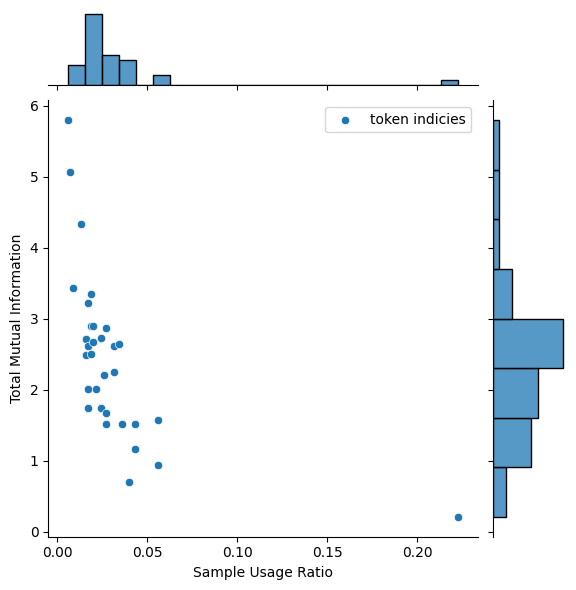

In [7]:
tpmi = pmi.sum(axis=0)

sorted_indicies = torch.argsort(token_prob)

most_sampled = token_prob[sorted_indicies]
corr_tpmi = tpmi[sorted_indicies]

df = pd.DataFrame({
    "Sample Usage Ratio": most_sampled,
    "Total Mutual Information": corr_tpmi
})

sns.jointplot(data=df, x='Sample Usage Ratio', y='Total Mutual Information', label="token indicies")
# Show the plot
plt.show()

tensor([[0.0008, 0.0008, 0.0009,  ..., 0.0007, 0.0004, 0.0006],
        [0.0008, 0.0015, 0.0011,  ..., 0.0010, 0.0007, 0.0010],
        [0.0009, 0.0011, 0.0013,  ..., 0.0008, 0.0004, 0.0006],
        ...,
        [0.0007, 0.0010, 0.0008,  ..., 0.0010, 0.0006, 0.0006],
        [0.0004, 0.0007, 0.0004,  ..., 0.0006, 0.0005, 0.0005],
        [0.0006, 0.0010, 0.0006,  ..., 0.0006, 0.0005, 0.0010]])


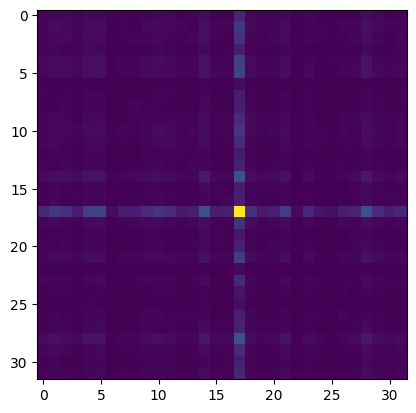

In [8]:
# Calculate the total sum of the matrix
total_sum = torch.sum(co_occurence)

# Calculate the probability of each token
token_prob = torch.sum(co_occurence, dim=0) / total_sum

# Calculate the joint probability of each pair of tokens
joint_prob = co_occurence / total_sum

print(joint_prob)
eps = 1e-10
# Ensure probabilities are normalized
token_prob = token_prob / token_prob.sum()
joint_prob = joint_prob / joint_prob.sum()

# Make sure the denominator is non-zero
denominator = torch.outer(token_prob, token_prob)
denominator = torch.clamp(denominator, min=eps)

# Calculate the mutual information
mutual_info = joint_prob / denominator
mutual_info = torch.clamp(mutual_info, min=eps)  # Ensure it's non-zero before taking log
mutual_info = torch.log2(mutual_info)
mutual_info = joint_prob * mutual_info  # joint_prob should multiply after taking log

# Mutual information should be non-negative; clamp it just in case
mutual_info = torch.clamp(mutual_info, min=0.0)

plt.imshow(joint_prob)

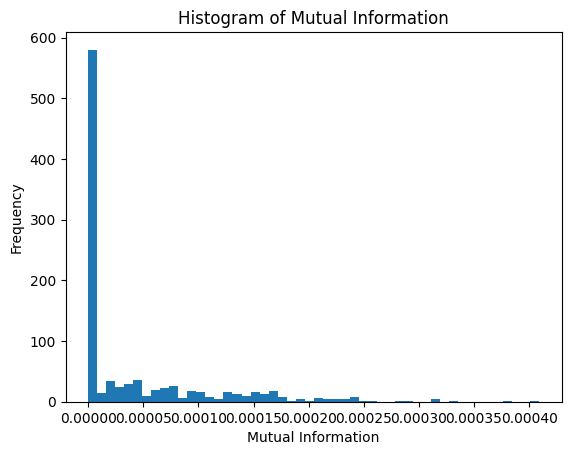

In [9]:
mutual_info = mutual_info.cpu().numpy()
mutual_info_no_diag = mutual_info.copy()
np.fill_diagonal(mutual_info_no_diag, np.nan)

# Flatten the matrix and remove NaN values
mutual_info_flat = mutual_info_no_diag.flatten()
mutual_info_flat = mutual_info_flat[~np.isnan(mutual_info_flat)]

# Plot the histogram
plt.hist(mutual_info_flat, bins=50)
plt.title('Histogram of Mutual Information')
plt.xlabel('Mutual Information')
plt.ylabel('Frequency')
plt.show()

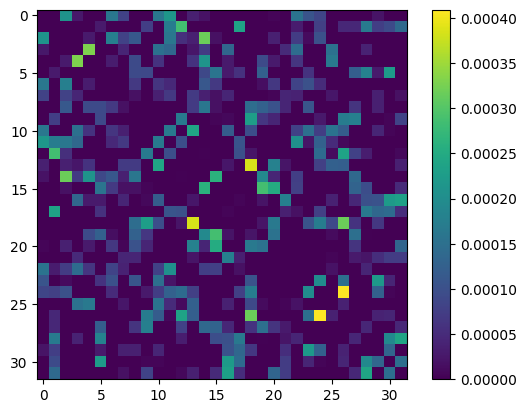

In [10]:
np.fill_diagonal(mutual_info, 0)
plt.imshow(mutual_info, interpolation="nearest")
plt.colorbar()
plt.show()

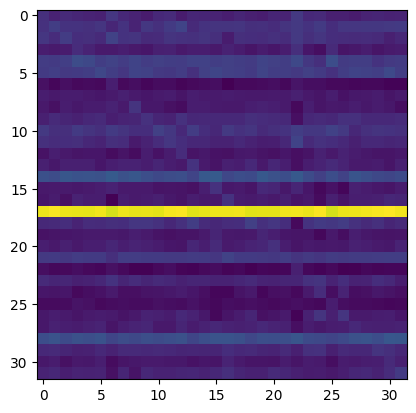

In [11]:
plt.imshow(conditional_prob)

In [19]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def tsne_vs_classifier_confidence(z_tr, z_te, y_tr):

    # Perform t-SNE on encoded data
    tsne = TSNE(n_components=2, random_state=0)
    Z_all_tsne = tsne.fit_transform(np.vstack((z_tr, z_te)))

    # Split t-SNE transformed data back into training and testing sets
    n_tr = z_tr.shape[0]
    Z_tr_tsne, Z_te_tsne = Z_all_tsne[:n_tr, :], Z_all_tsne[n_tr:, :]

    # Train classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    svm = SVC(kernel="linear")

    knn.fit(z_tr, y_tr)
    svm.fit(z_tr, y_tr)

    knn_confidence_scores = knn.predict_proba(z_te)
    svm_confidence_scores = svm.decision_function(z_te)
    svm_confidence_scores = (
        svm_confidence_scores - svm_confidence_scores.min()
    ) / (svm_confidence_scores.max() - svm_confidence_scores.min())

    # Visualize t-SNE with classifier confidence
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        Z_te_tsne[:, 0],
        Z_te_tsne[:, 1],
        c=knn_confidence_scores,
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(scatter, label="KNN Confidence")
    plt.title("t-SNE Visualization Colored by KNN Confidence")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        Z_te_tsne[:, 0],
        Z_te_tsne[:, 1],
        c=svm_confidence_scores,
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(scatter, label="SVM Confidence")
    plt.title("t-SNE Visualization Colored by SVM Confidence")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

In [18]:

from evaluation.downstream_eval import encode_data

encoder = maskgit.encoder.to("cuda")
vq_model = maskgit.vq_model.to("cuda")

z_tr, y_tr, _ = encode_data(
    dataloader=train_data_loader_no_aug,
    encoder=encoder,
    n_fft=config["VQVAE"]["n_fft"],
    vq_model=vq_model,
    avg_pooling=True,
    device="cuda",
    num_tokens=32
)

z_te, y_te, _ = encode_data(
    dataloader=test_data_loader_no_aug,
    encoder=encoder,
    n_fft=config["VQVAE"]["n_fft"],
    vq_model=vq_model,
    avg_pooling=True,
    device="cuda",
    num_tokens=32
)

In [21]:
tsne_vs_classifier_confidence(
    z_tr=z_tr.cpu().numpy(), z_te=z_te.cpu().numpy(), y_tr=y_tr.cpu().numpy()
)